# EDA and Wrangling<a id='Data_Wrangling'></a>

## Table of Contents
* [Introduction](#Introduction)
* [0 Imports](#Imports)
* [1 - Data Acquisition](#Acquisition)
  * [1.1 Web Scraping for Images](#ddg)
    * [1.1.1 Defining our web search terms](#websearch)
    * [1.1.2 Downloading the Images](#download)
  * [1.2 Import Locally Sourced Images](#gdrive)
* [2 - Phase 1 EDA wrap-up](#phase1)
  * [2.1 Image Inspection](#inspect)
  * [2.2 Compress Data](#compression)
    * [2.2.1 zip images](#zip)
  * [2.3 Run the baseline model](#baseline)
* [3 - Addressing Class Imbalance](#classimb)
  * [3.1 Flip](#flip)
  * [3.2 Random Crop](#crop)

![cstore photo](207.jpg)

## Introduction<a id='Introduction'></a>

This project seeks to build a merchandising category classifier. Using inventory images, a convolutional neural network will classify what category the set of products belongs to. In the retail industry, this is a <em>highly</em> subjective decision. Where a product gets merchandised in a store is neither an organized nor a random process. It is somewhere in between. Items are merchandised based on "schematics" and "planograms." In some cases, large product manufacturers lobby with large retailers to compete for the best position in the store. Auditors are sent to ensure products are merchandised properly, but this is never possible, due to complex logistics & supply chains, out-of-stocks, and the physical ability and skill of store employees to properly restock. Neverthless, we hypothesize that we can build a model with relatively good performance. In the words of George Box, all models are wrong, but some are useful.

This is a notebook of Exporatory Data Analysis (EDA) and Data Wrangling. EDA and Data Wrangling are the second and third steps of the Data Science Pipeline, the first step being problem identification, which was just mentioned in the prior paragraph. The proceeding notebook after this one will be modeling.

The steps of this notebook are data acquisition, EDA, and Wrangling. In the first step, we scrape the data from the web using a python library called duckduckgo_search. Images were also taking by the creator of this notebook and organized accordingly. Simple EDA and inspection of the images is done, and then the first batch is sent off to a different notebook (modeling). We attempt to improve the model results with more wrangling, specifically addressing class imbalance by applying image augmentation to underrepresented classes.

## 0 Imports<a id='Imports'></a>

In [2]:
#!pip install -Uqq duckduckgo_search

%matplotlib inline

#data acquisition and wrangling
import requests
from duckduckgo_search import DDGS
from pathlib import Path
import gdown
import zipfile

#image processing
from PIL import Image
from skimage.color import rgb2gray
from skimage.transform import rotate
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import seaborn as sns

In [73]:
image_path = Path('/Users/dennisfrancis/Capstone 3/cstore images/cstore_images')

## 1 Data Acquisition<a id='Acquisition'></a>

### 1.1 Web Scraping for Images<a id='ddg'></a>

With the duckduckgo_search library, we can search for words, documents, images, and text using the DuckDuckGo.com search engine. Per the documentation, we use the <em>images</em> class method within a context manager, which returns a list of image urls:

```pytnon
with DDGS() as ddgs:
    generator = ddgs.images('search term', max_results=20)
    for item in generator:
        append to some list
```

#### 1.1.2 defining our web search terms<a id='websearch'></a>

The problem is image classification. We arrange our search terms in a dictionary as follows. Each class will be a dictionary key, and the dictionary value for such key will be a collection of search terms.

```python
search_query = {'category_1': ['search_query_1', 'search_query_2'],
                'category_2': ['search_query_1', 'search_query_2']}
```

In [3]:
#search terms are labeled by category for the classification problem. 
#There are 5 categories, and 1 'other' category

search_terms = {
    'candy': [
        'confectionary',
        'convenience store candy',
        'reeses hersheys candy convenience store',
        'pegged candy merchandised',
        'non chocolate convenience store',
        'convenience store candy'
    ],
    'chips': [
        'convenience store chips',
        'fritolay chips convenience store',
        'chips merchandise convience store',
        'chips merchandise grocery store',
        'merchandising chips store reset'
    ],
    'cigarettes': [
        'convenience store cigarettes',
        'cigarette merchandise',
        'cigarette display merchandise convenience store',
        'cigarettes and tobacco merchandise'
    ],
    'drinks': [
        'cooler drinks merchandise',
        'soda cooler with drinks',
        'ice cold beverages convenience store', 
        'convenience store drinks'
    ],
    'ice cream': [
        'convenience store ice cream',
        'ice cream display convenience store', 
        'pint ice cream merchandise',
        'ice cream convenience store', 
        'ice cream merchandiser'
    ],
    'other': [
        'nutritional bar display convenience store',
        'beef jerky merchandise convenience store',
        'cookies merchandise convenience store', 
        'grocery merchandise convenience store'
    ]
}

#we will search results of image urls here
search_results = {
    'candy':[],
    'chips':[],
    'cigarettes':[],
    'drinks':[],
    'ice cream':[],
    'other':[]
}

for label, search_values in search_terms.items():

    for specific_term in search_values:
        with DDGS() as ddgs:
            keywords = specific_term
            ddgs_images_gen = ddgs.images(
              keywords,
              region="wt-wt",
              safesearch="off",
              size=None,
              #color="Monochrome",
              type_image=None,
              layout=None,
              license_image=None,
              max_results=80,
            )

            #save the search results of image urls here in search_results dict
            for r in ddgs_images_gen:
                search_results[label].append(r)

In [6]:
#inspect the number of search urls returned
nums = []
for cat in search_results.keys():
    nums.append(len(search_results[cat]))
total_image_urls = sum(nums)

print(f"{total_image_urls} urls returned.")

2240 urls returned.


#### Download the Images <a id='download'></a>
The following code block will iterate through the dictionary of search urls returned, and perform <code>requests.get(url)</code> for each url. If the status code is 200, we attempt to write the binary image file to drive.

In [8]:
for category in search_results.keys():
    path = Path(category)
    #after running once, program got "stuck" after downloading hundreds of images.
    #added this line path.exists() to run cell again and not overwrite files
    if not path.exists():
        path.mkdir(parents=True, exist_ok=True)
        for item in search_results[category]:
            filename = item['title'] + item['image'][-4:]
            filepath = path / filename
            #my_list.append(filename)
            try:
                r = requests.get(item['image'])
            except:
                pass
            else:
                if r.status_code == 200:
                    # write image as binary, named file the index number and the last 4 chars --'.jpg'

                    try:
                        with open(filepath, "wb") as file:
                            file.write(r.content)
                    except:
                        pass

### 1.2 Locally Sourced Images<a id='ddg'></a>

Sourcing data for a project could be difficult in some circumstances. In a hypothetical scenario, there would be fixed camaras inside a store taking pictures of the inventory. Or there might be a merchandising auditor taking pictures with a smartphone. With neither of these scenarios being true, I decided to take more pictures myself to add to the training data. I visited five stores within my area: 2 local gas station convenience stores, two grocery stores, and two dollar/value stores.

I have already uploaded the photos to my computer (1,457 images) and moved them to <code>'/Users/dennisfrancis/Capstone 3/import_folder'</code>. This simple terminal command simply takes the images and uploades them to google drive. Note: You can do terminal commands from the notebook by prepending them with an exclamation point <code>!gdown --id google_id -O file_source --folder --remaining-ok</code>

In [11]:
#move files into "import folder"
path = Path('import_folder').mkdir(parents=True, exist_ok=True)

In [61]:
pwd

'/Users/dennisfrancis/Capstone 3/import_folder'

In [37]:
!gdown --id 1Pyk8i1k5_DpmKjbloQ-SK61De2EzXvOi -O /Users/dennisfrancis/Capstone\ 3/import_folder --folder --remaining-ok

/opt/anaconda3/lib/python3.9/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Retrieving folder list


## 2 Phase 1 EDA wrap-up<a id='phase1'></a>

### 2.1 Image Inspection<a id='inspect'></a>

We now view the images prior to terminating this preliminary phase of EDA and image wrangling.

##### Function for previewing each category

In [33]:
def preview_batch(cat):
    """preview a small batch size of photos"""
    
    image_path = Path(f'~/Capstone 3/cstore images/cstore_images/{cat}').expanduser()

    for idx, item in enumerate(image_path.iterdir()):
        if idx <= 3:
            im = plt.imread(item)
            plt.imshow(im)
            plt.axis('off')
            plt.show()

##### Candy

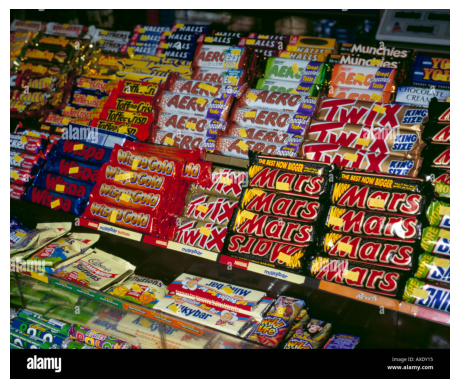

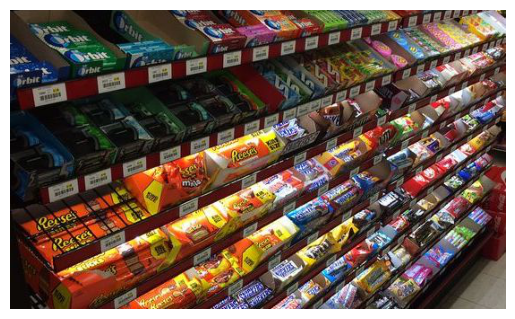

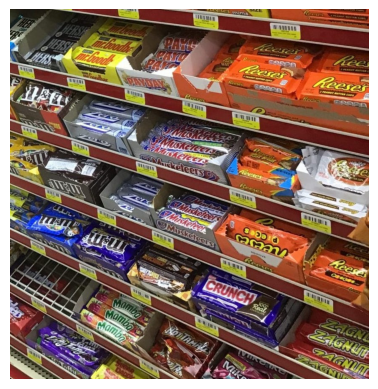

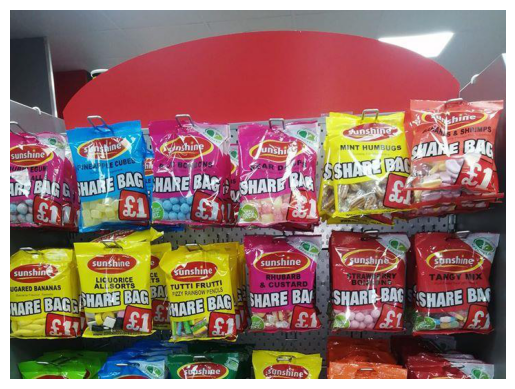

In [34]:
preview_batch('candy')

##### Drinks

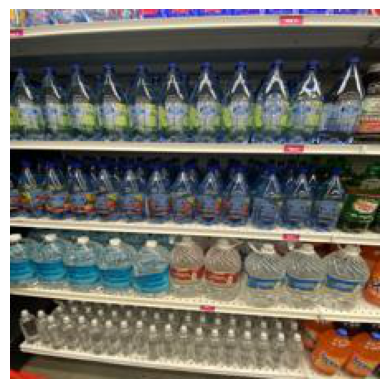

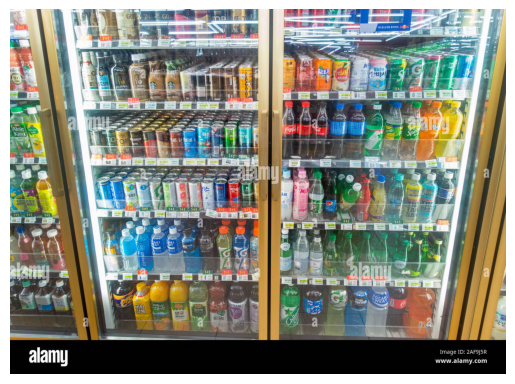

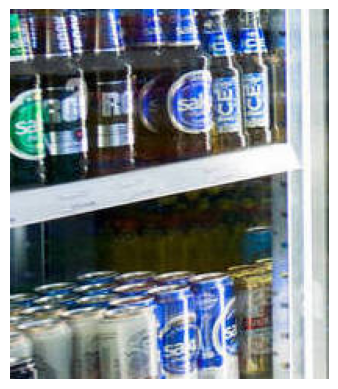

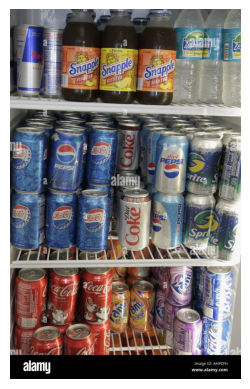

In [35]:
preview_batch('drinks')

##### Cigarettes

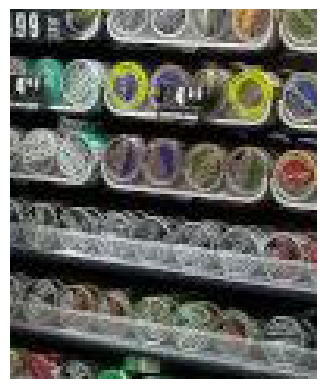

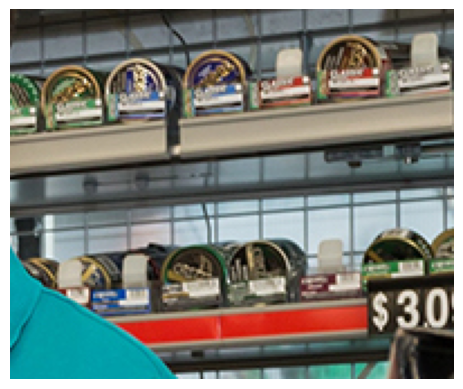

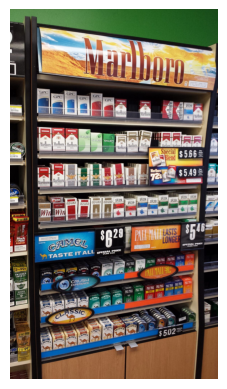

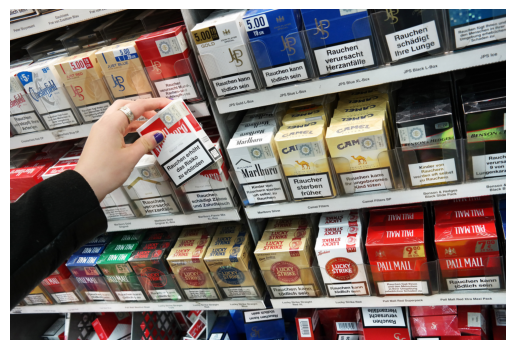

In [36]:
preview_batch('cigarettes')

In [111]:
cd /Users/dennisfrancis/Capstone\ 3/import_folder/other

/Users/dennisfrancis/Capstone 3/import_folder/other


In [81]:
path.mkdir(parents=True, exist_ok=True)

In [112]:
#id is a random number so file names don't overlap
id = 4456
for item in path.iterdir():
    item.rename(str(id)+item.name[-4:])
    id += 1

### 2.2 Compress image files for later use<a id='compression'></a>

#### 2.2.1 zip image files<a id='zip'><a/>

In [32]:
import zipfile

folder_to_compress = Path('/Users/dennisfrancis/Capstone 3/cstore images')

zip_archive_name = 'cstore_images.zip'

with zipfile.ZipFile(zip_archive_name, 'w', zipfile.ZIP_DEFLATED) as archive:
    for file_path in folder_to_compress.glob('**/*'):
        if file_path.is_file():
            archive.write(file_path, file_path.relative_to(folder_to_compress))

In [28]:
# show the .zip file of images
path = Path()
zipped_files = path.glob('*.zip')
print("Here are the images we can take to the next step of the Data Science Pipeline, modeling:\n")
print("   ---> ",*zipped_files, "  <---\n")

Here are the images we can take to the next step of the Data Science Pipeline, modeling:

   --->  cstore_images.zip   <---



In [31]:
pwd

'/Users/dennisfrancis/Capstone 3'

### 2.3 Running the baseline model<a id='baseline'></a>

See other notbook (pre-processsing and modeling) for specifics of how the baseline model was implemented

error rate - 18%

## 3 Adressing Class Imbalance<a id='classimb'></a>

#### Basic Image Augmentation
In the modeling notebook, we will use a library called fastai that runs PyTorch under the hood. This library has a function call that will automatically apply standard best-practice image augmentation for Deep Learning, as in different rotations, lighting and contrast differences, etc.

However, the library cannot balance out the class imbalance here, so we must manually augment the classes that are lacking in number. We will use two simple image augmentation techniques, flipping/reflecting the image, and random resizing and cropping. 

##### Creating a function that return the number of images per class

In [48]:
def check_class_imbalance():
    """check for class imbalance"""
    classes = {}
    image_categories = Path('/Users/dennisfrancis/Capstone 3/cstore images/cstore_images')
    for cat in image_categories.iterdir():
        if cat.name == ".DS_Store":
            continue
        classes[cat.name] = 0
        for im in cat.iterdir():
            classes[cat.name] += 1
    
    class_counts = class_counts = pd.Series(classes)
    class_percentages = pd.Series([cat/class_counts.sum() for cat in class_counts]) * 100
    
    return class_counts, class_percentages

In [57]:
class_counts, class_percentages = check_class_imbalance()

print(class_counts)
print("\n")
print(class_percentages)

drinks        278
chips         255
other         214
Ice cream     207
cigarettes    196
candy         284
dtype: int64


0    19.386332
1    17.782427
2    14.923291
3    14.435146
4    13.668061
5    19.804742
dtype: float64


####  A note on jupyter notebooks: the order matters
The numbers in the cell above are actually much better compared to what the original class imbalance was. The original class imbalance is seen in the bar chart below. What happened was is that I flipped images to duplicate and then ran the cells above again, erasing my previous work. I then made a function to replicate and check for class imbalance more easily.

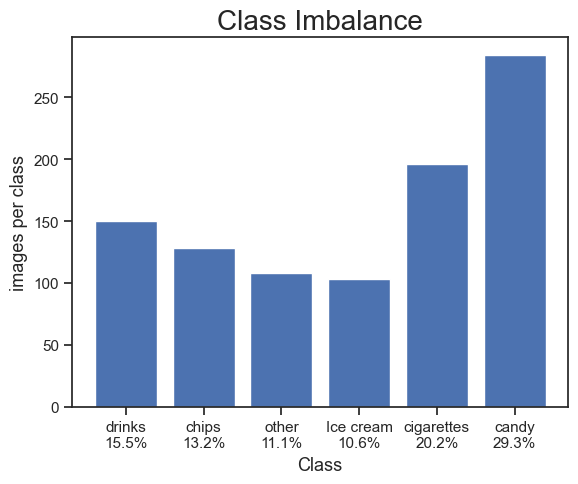

In [166]:
# do not run

sns.set()
sns.set_style("ticks")

fix, ax = plt.subplots()
ax.bar(class_counts.index, class_counts)

ax.set_xticks(class_counts.index)
ax.set_xticklabels(class_counts.index + '\n' + 
                   class_percentages.round(1).astype(str)+ '%')
ax.set_xlabel('Class', fontsize=13)
ax.set_ylabel('images per class', fontsize=13)

ax.set_title("Class Imbalance", fontsize=20)

plt.show()

##### Wrap the above code into a function for future use:

In [58]:
def graph_class_imbalance():
    """bar chart of the class imbalance"""
    class_counts, class_percentages = check_class_imbalance()
    
    sns.set()
    sns.set_style("ticks")

    fix, ax = plt.subplots()
    ax.bar(class_counts.index, class_counts)

    ax.set_xticks(class_counts.index)
    ax.set_xticklabels(class_counts.index + '\n' + 
                       class_percentages.round(1).astype(str)+ '%')
    ax.set_xlabel('Class', fontsize=13)
    ax.set_ylabel('images per class', fontsize=13)

    ax.set_title("Class Imbalance", fontsize=20)

    plt.show()

### 3.1 Flip Images <a id='flip'></a>
The first step will be some simple image transformations to make the classes more balanced.

In [38]:
# iterate through directory tree in order to access the image files:
image_categories = Path('/Users/dennisfrancis/Capstone 3/cstore images/cstore_images')

for cat in image_categories.iterdir():
    #ignore a hidden file that MacOS produces in the background
    if cat.name == '.DS_Store':
        continue
    
    # we need to increase the number of images in these categories:
    if cat.name in ['chips', 'other', 'Ice cream', 'drinks']:
        
        # apply image processing to individual image files here
        dest_parent = image_categories / cat.name
        
        for im_file in cat.iterdir():
            
            if im_file.name == '.DS_Store':
                continue
            
            try:
                im = plt.imread(im_file)
            except:
                continue
            
            try:
                im2 = np.fliplr(im)
            except:
                continue

            dest = dest_parent / ("flipped " + im_file.name)

            try:
                plt.imsave(dest, im2)
            except:
                continue

In [47]:
check_class_imbalance()

drinks        278
chips         255
other         214
Ice cream     207
cigarettes    196
candy         284
dtype: int64

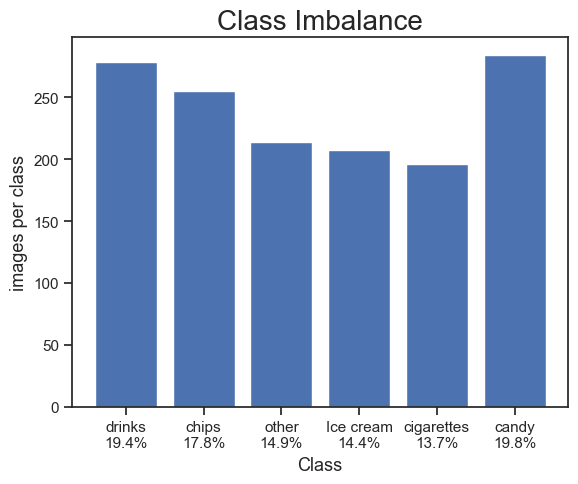

In [59]:
graph_class_imbalance()

In [173]:
path = Path('/Users/dennisfrancis/Capstone 3/cstore images/cstore_images')
for item in path.iterdir():
    print(item.name)

drinks
.DS_Store
chips
other
Ice cream
cigarettes
candy


### 3.2 Random Crop<a id='crop'></a>

Some images are great for cropping because no matter how you crop it, it preserves the character of what you are trying to classify, in this case cigarettes:

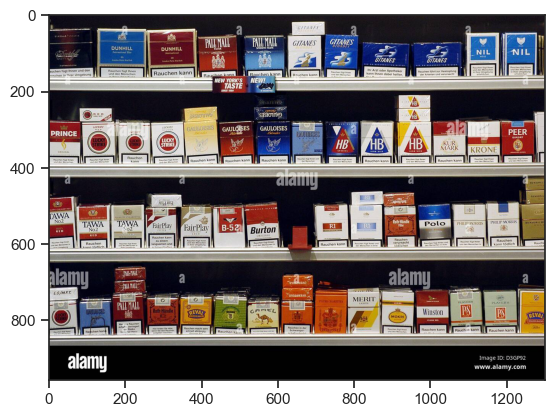

In [76]:
example = 'cigarettes/cigarettes in germany.jpg'
im = plt.imread(image_path / example)
plt.imshow(im)

Observe that if we crop this image randomly, we can increase the number of unique, quality images to feed our model at no additional cost:

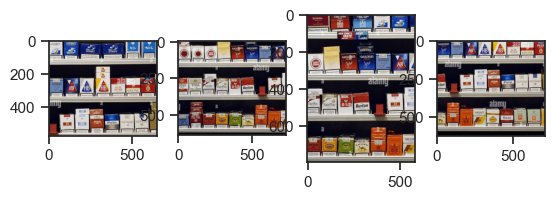

In [81]:
crop_1 = plt.imread(image_path / 'cigarettes/cigarettes in germany crop 1.jpg')
crop_2 = plt.imread(image_path / 'cigarettes/cigarettes in germany crop 2.jpg')
crop_3 = plt.imread(image_path / 'cigarettes/cigarettes in germany crop 3.jpg')
crop_4 = plt.imread(image_path / 'cigarettes/cigarettes in germany crop 4.jpg')

fig, ax = plt.subplots(1, 4)
ax[0].imshow(crop_1)
ax[1].imshow(crop_2)
ax[2].imshow(crop_3)
ax[3].imshow(crop_4)

Note how all of the pictures have been cropped from one image. These extra images will balance out the classes and also will provide additional information to train our model. Note: theses images were manaully cropped using a photo editor.

##### function for randomly cropping out images
It would be convenient to write a function that could automatically crop images. This function would help create more images to balance out the classes

In [84]:
# check the dimensions of the image
im.shape

(956, 1300, 3)

In [133]:
def random_crop(im):
    """randomly resize and crop and image"""
    #extract image dimensions for a random resize crop function
    pixel_rows = im.shape[0]
    pixel_cols = im.shape[1]
    
    col_len = 800
    row_len = 1
    
    while col_len / row_len < 0.3 or col_len / row_len > 3:

        start_row = np.random.choice(int(pixel_rows/2) - 2)
        row_len = int(pixel_rows / 2) + start_row
        
        start_col = np.random.choice(int(pixel_cols/2)-2)
        col_len = int(pixel_cols / 2 ) + start_col
    
    return im[start_row:row_len, start_col:col_len, : ]



In [134]:
np.random.choice(int(965/2))

172

We now have a function we can call that will rapidly produce cropped images.

In [190]:
def process_images(input_path, sub_directories, func, same_dir=True, diff_dest=None, title='processed '):
    """process input function on images in subdirectories of a given file path"""

    # iterate through directory tree in order to access the image files:
    for cat in input_path.iterdir():
        if cat.name == '.DS_Store':
            continue
        if not cat.is_dir():
            print('file tree structure does not match. please pass a path with sub directories.')
            break

        # we need to increase the number of images in these categories:
        if cat.name in sub_directories:

            # apply image processing to individual image files here
            dest_parent = input_path / cat.name

            for im_file in cat.iterdir():

                if im_file.name == '.DS_Store':
                    continue

                try:
                    im = plt.imread(im_file)
                except:
                    continue

                try:
                    im2 = func(im)
                except:
                    continue

                #create a unique identifier so files don't get overwritten (small probability that some will)
                upc = str(np.random.random())[2:8]
                
                #apply a prefix to the operation just performed (see the keyword arg `title`)
                if same_dir == True:
                    # save the files in the same directory they came from
                    dest = dest_parent / (title + upc + im_file.name)
                else:
                    dest = diff_dest / cat.name / (title + upc+ im_file.name)

                try:
                    plt.imsave(dest, im2)
                except:
                    continue

In [193]:
#desired images to be cropped are placed in this directory
input_images_path = Path('/Users/dennisfrancis/test/photos')

#cropped images will be output to this directory
processed_images_dest = Path('/Users/dennisfrancis/test/test_results')

In [194]:
for _ in range(10):
    process_images(input_images_path, ['other', 'Ice cream', 'cigarettes'], 
                   random_crop, same_dir=False, diff_dest=processed_images_dest,  title='cropped ')

Let's check out our class counts to see where we are at...

In [195]:
check_class_imbalance()

(drinks        273
 chips         255
 other         284
 Ice cream     279
 cigarettes    267
 candy         284
 dtype: int64,
 0    16.626066
 1    15.529842
 2    17.295981
 3    16.991474
 4    16.260658
 5    17.295981
 dtype: float64)

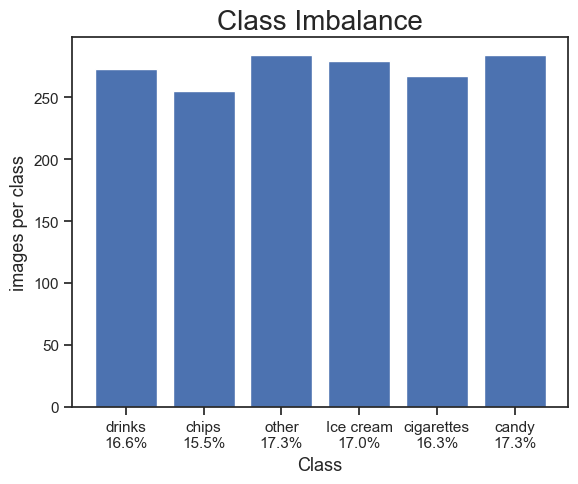

In [196]:
graph_class_imbalance()

Amazing!! We no longer have class imbalance. The Data science process is not linear. One can and should jump from wrangling, to modeling, back to preprocessing, modeling, wrangle and explore more, then model. This is normal. Let's take the data back to modeling and see if results have improved...

In [198]:
# compress and export the files

folder_to_compress = Path('/Users/dennisfrancis/Capstone 3/cstore images')

zip_archive_name = 'cstore_images_3.zip'

with zipfile.ZipFile(zip_archive_name, 'w', zipfile.ZIP_DEFLATED) as archive:
    for file_path in folder_to_compress.glob('**/*'):
        if file_path.is_file():
            archive.write(file_path, file_path.relative_to(folder_to_compress))

In [199]:
pwd

'/Users/dennisfrancis/test/photos/other'